In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Explore Data
**View and understand data. See shape and length of dataset.**

In [ ]:
raw_dataset = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
(X_train, y_train),(X_test, y_test) = raw_dataset

In [ ]:
print("Length X train: ", len(X_train))
print("Length y train: ", len(y_train))
print("Length X test: ", len(X_test))
print("Length y test: ", len(y_test))

Length X train:  60000
Length y train:  60000
Length X test:  10000
Length y test:  10000


In [ ]:
np.shape(X_train)

(60000, 28, 28)

In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

4

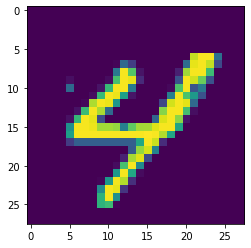

In [ ]:
#Check image and corresponding value
n = 89
plt.imshow(X_train[n])
y_train[n]

In [ ]:
#Scale training and test input data
X_train = X_train/255
X_test = X_test/255

#Create and Fit Autoencoder
**Create encoder with desired layers and matching decoder. Fit autoencoder to data.**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Create encoder for dimension reduction.
encoder = Sequential()
encoder.add(Flatten(input_shape=[28,28]))
encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))
encoder.add(Dense(10, activation='relu'))
encoder.add(Dense(5, activation='relu'))

In [ ]:
#Create decoder to recreate "reduced" image of the encoder.
decoder = Sequential()
decoder.add(Dense(10,activation='relu',input_shape=[5]))
decoder.add(Dense(25,activation='relu'))
decoder.add(Dense(50,activation='relu'))
decoder.add(Dense(100,activation='relu'))
decoder.add(Dense(200,activation='relu'))
decoder.add(Dense(400,activation='relu'))
decoder.add(Dense(784,activation='sigmoid'))
decoder.add(Reshape([28,28]))

In [ ]:
#Create autoencoder model from the encoder and decoder created above.
autoencoder = Sequential([encoder,decoder])
autoencoder.compile(loss="binary_crossentropy", optimizer=SGD(lr=1.5), metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
#Fit autoencoder to data with earlystop. Iterate to get best epoch if earlystop not effected.
autoencoder.fit(X_train, X_train, epochs=100, validation_data=(X_test, X_test), callbacks=[earlystop])

Epoch 1/100
1875/1875 [==============================] - 21s 10ms/step - loss: 0.2609 - accuracy: 0.0786 - val_loss: 0.2357 - val_accuracy: 0.1025
Epoch 2/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2205 - accuracy: 0.1156 - val_loss: 0.2085 - val_accuracy: 0.1288
Epoch 3/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2042 - accuracy: 0.1378 - val_loss: 0.2088 - val_accuracy: 0.1287
Epoch 4/100
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1937 - accuracy: 0.1540 - val_loss: 0.1887 - val_accuracy: 0.1667
Epoch 5/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1844 - accuracy: 0.1700 - val_loss: 0.1784 - val_accuracy: 0.1753
Epoch 6/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1775 - accuracy: 0.1801 - val_loss: 0.1728 - val_accuracy: 0.1869
Epoch 7/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1732 - accuracy: 0.1884 - val_loss: 0

In [ ]:
encoder.save("reduced_encoder.h5")
decoder.save("reduced_decoder.h5")
autoencoder.save("reduced_autoencoder.h5")

#Autoencoder Prediction and Evaluation
**Predict test data with trained autoencoder. Compare and review results**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

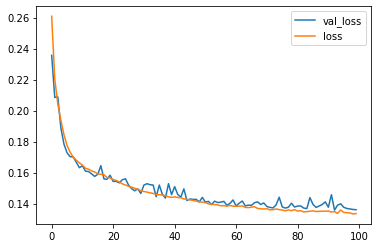

In [ ]:
#Plot losses to see how well model fitted. Check for signs of under / overfitting.
result = pd.DataFrame(autoencoder.history.history)
result[['val_loss','loss']].plot()

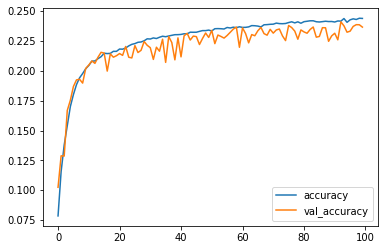

In [ ]:
result[['accuracy','val_accuracy']].plot()

In [ ]:
#Pass 10 test images to encoder for prediction.
predictions = autoencoder.predict(X_test[:20]) 

In [ ]:
np.shape(predictions)

(20, 28, 28)

Predicted Image


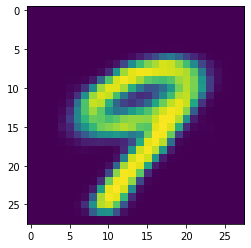

Original test image


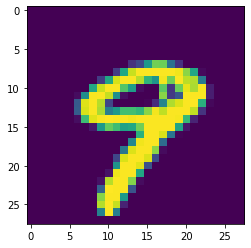

In [ ]:
#Review quality of recreated images vs original.
n=9
print("Predicted Image")
plt.imshow(predictions[n])
plt.show()
print("Original test image")
plt.imshow(X_test[n])
plt.show()

# Data Prepocessing for Fitting with Encoded Images
**Apply trained encoder (without decoder) to fresh dataset to reduce image dimension from [28, 28] to [5].**

In [ ]:
#Load a new train and test set for training and fitting of new model.
(X2_train, y2_train),(X2_test, y2_test) = raw_dataset

In [ ]:
#Change y values to categories instead of numeric
ycat_train = to_categorical(y2_train)
ycat_test = to_categorical(y2_test)

In [ ]:
#Scale training values
X2_train = X2_train/255
X2_test = X2_test/255

In [ ]:
#Encode images in the data set using encoder trained in the previous section.
#Turn image from [28, 28] to [5]
encoded_X_train = encoder.predict(X2_train)
encoded_X_test = encoder.predict(X2_test)

In [ ]:
#Check encoded "image" shape.
encoded_X_train.shape

(60000, 5)

In [ ]:
encoded_X_test.shape

(10000, 5)

# Model Creation and Fitting
**Create model to classify the encoded data (i.e. images of dimensions of [5]). Fit model to the encoded data.**

In [ ]:
#Create and compile model.
model = Sequential()

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#Fit model to encoded data.
model.fit(encoded_X_train,ycat_train, validation_data=(encoded_X_test,ycat_test),epochs=30, callbacks=[earlystop])

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0779 - val_loss: 0.4411
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5483 - val_loss: 0.3395
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4573 - val_loss: 0.2998
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4206 - val_loss: 0.2839
Epoch 5/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3975 - val_loss: 0.2790
Epoch 6/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3827 - val_loss: 0.2657
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3711 - val_loss: 0.2631
Epoch 8/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3696 - val_loss: 0.2605
Epoch 9/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3629 - val_loss: 0.2565
Epoch 10/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.360

In [ ]:
model.save("reduced_model.h5")

# Model Evaluation and Prediction
**Predict test set using trained model. Evaluate performance and results.**

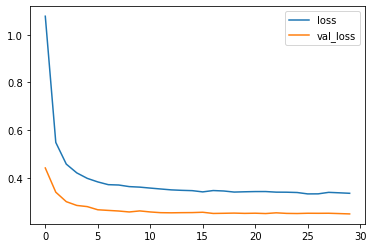

In [ ]:
#Plot losses to see how well model fitted. Check for signs of under / overfitting.
metrics = pd.DataFrame(model.history.history)
metrics.plot()

In [ ]:
#Predict on the encoded test set and review performance.
predictions2 = np.argmax(model.predict(encoded_X_test),axis=-1)
predictions2

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
y2_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
#See statictics of prediction. See categories that performed well and badly.
print(classification_report(y2_test,predictions2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.90      0.91      0.91      1010
           4       0.95      0.91      0.93       982
           5       0.91      0.88      0.90       892
           6       0.97      0.98      0.97       958
           7       0.93      0.94      0.93      1028
           8       0.88      0.93      0.91       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



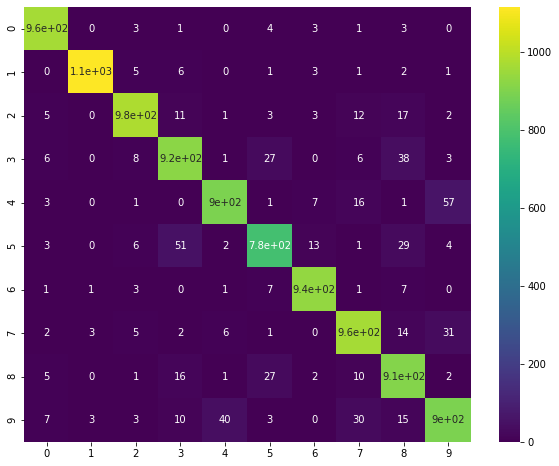

In [ ]:
#Use heatmap to see the confusion matrix on the false negatives and false positives .
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y2_test,predictions2),cmap='viridis', annot=True)

#Results
Accuracy ==> 94% of the total predictions were predicted correctly.

Highest Precision ==> For the following 3 numbers have the highest precision. The percentage indicates the proportion of the prediction (True + False Positives) that were actually correct (True Positives).

* Number 1 - 99%
* Number 0,2,6 - 97%
* Number 4 - 95%

Poorest Precision ==> For the following 3 numbers have the highest precision.

* Number 8 - 88%
* Number 3,9 - 90%
* Number 5 - 91%

Highest Recall ==> For the following 3 numbers have the highest recall. The percentage indicates the proportion of the correct data (True Positives + False Negatives) is actually predicted correctly (True Positives).

* Number 0,1,6 - 98%
* Number 2 - 95%
* Number 7 - 94%

Poorest Recall ==> For the following 3 numbers have the poorest recall.

* Number 5 - 88%
* Number 9 - 89%
* Number 3,4 - 91%



Confused Prediction by Numbers ==> Below shows some numbers that are mistaken for the others as indicated by the lighter colors in the heatmap (outside the diagonal squares).

* Number 4 and 9
* Number 3 and 5
* Number 3 and 8

#Analysis
* Model has a 4% lower accuracy of 94% when compared to the Standard model (98%).
* However, the Standard model used images of [28,28] elements while this Reduced model uses images of [5] elements.
* With reference to the heat map, the model mistaked a high number of 9s for number 4s. A review of some of the images of the decoded 9s showed that the top part of 9s were frequently diminished to such an extent that it resembled a number 4.
* In summary, this experiment attempted to test the performance of dimension reduction of a simple autoencoder. More can done to balance the performance by reducing the reduction to improve on the prediction accuracy.
